# Some regularizations and optimization algorithms on [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset
By [Zahra Taheri](https://github.com/zahta), November 27, 2020

### Preperation for Google colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#unzip dataset files from google drive to content folder in colab

import os

if os.path.exists("/content/cifar-10-batches-py/")==False:
  print("unzip files!")
  !unzip -q "/content/drive/My Drive/cifar-10-batches-py.zip"

mypath="/content/cifar-10-batches-py/"

unzip files!


In [3]:
#Define path to the directory
 
os.chdir(mypath)

print(os.getcwd())

/content/cifar-10-batches-py


### Import libraries

In [4]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary

import matplotlib as mpl
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings('ignore')

# Set the seeds to ensure reproducibility
np.random.seed(1)
torch.manual_seed(1)

## Loading CIFAR-10

In [5]:
%run load_cifar10.py

In [6]:
#Define path to the directory
 
os.chdir("/content/")

print(os.getcwd())

/content


In [7]:
cifar_10_dir = 'cifar-10-batches-py'
train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
load_cifar_10_data(cifar_10_dir)
print("Train data: ", train_data.shape)
print("Train filenames: ", train_filenames.shape)
print("Train labels: ", train_labels.shape)
print("Test data: ", test_data.shape)
print("Test filenames: ", test_filenames.shape)
print("Test labels: ", test_labels.shape)
print("Label names: ", label_names.shape)

Train data:  (50000, 32, 32, 3)
Train filenames:  (50000,)
Train labels:  (50000,)
Test data:  (10000, 32, 32, 3)
Test filenames:  (10000,)
Test labels:  (10000,)
Label names:  (10,)


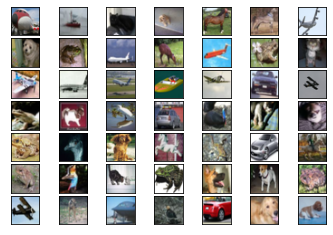

In [8]:
# display some random training images
num_plot = 7
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
    for n in range(num_plot):
        idx = np.random.randint(0, train_data.shape[0])
        ax[m, n].imshow(train_data[idx])
        ax[m, n].get_xaxis().set_visible(False)
        ax[m, n].get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()

## Preparation of the dataset

In [9]:
#nsamples1, a1,b1,c1 = train_data.shape
#X_train= train_data.reshape((nsamples1,a1*b1*c1))
#nsamples2, a2,b2,c2 = test_data.shape
#X_test= test_data.reshape((nsamples2,a2*b2*c2))

# Data standardization
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test= scaler.transform(X_test)

#train_data = X_train.reshape((nsamples1, a1,b1,c1))
#test_data= X_test.reshape((nsamples2, a2,b2,c2))

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader

tensor_x = torch.Tensor(train_data) # transform to torch tensor
tensor_y = torch.Tensor(train_labels)
tensor_y = tensor_y.type(torch.LongTensor)

train_dataset = TensorDataset(tensor_x,tensor_y) # create your dataset

In [11]:
tensor_x2 = torch.Tensor(test_data)
tensor_y2 = torch.Tensor(test_labels)
tensor_y2 = tensor_y2.type(torch.LongTensor)

test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [12]:
tensor_y

tensor([6, 9, 9,  ..., 9, 1, 1])

## Building Feedforward Neural Networks with PyTorch

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 3*32*32).to(device)
            targets = targets.to(device)
            outputs = net.forward(features)
            predicted_labels = torch.argmax(outputs, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100        
            
            

def compute_loss(net, data_loader):
    curr_loss = 0.
    with torch.no_grad():
        for cnt, (features, targets) in enumerate(data_loader):
            features = features.view(-1, 3*32*32).to(device)
            targets = targets.to(device)
            outputs = net.forward(features)
            loss = criterion(outputs, targets)
            curr_loss += loss
        return float(curr_loss)/cnt

## Regularizations (Ensemble Methods)

- [Ensembles: the only (almost) free Lunch in Machine Learning](https://towardsdatascience.com/ensembles-the-almost-free-lunch-in-machine-learning-91af7ebe5090)
    - Build optimal ensembles of neural networks with PyTorch and NumPy
    
    
- [Bagging and Dropout Learning](https://jrodthoughts.medium.com/bagging-and-dropout-learning-ae484023b0da)

### Dropout: Ensemble Method Interpretation
**Reference:** [Regularization by Sebastian Raschka](https://sebastianraschka.com/pdf/lecture-notes/stat479ss19/L10_regularization_slides.pdf)

- In DL, we typically don't do regular ensembling (majority vote over a large number of networks, bagging, etc.) because it is very expensive to fit neural nets.
- However, we know that the squared error for a prediction by a randomly selected model is larger than the squared error using an ensemble prediction (here, average over class probabilities).
- Now, in dropout, we have a different model for each minibatch. 
- Via the minibatch iterations, we essentially sample over $M=2^h$ models, where h is the number of hidden units.
- Restriction is that we have weight sharing over these models, which can be seen as a form of regularization.
- During "inference" we can then average over all these models (but this is very expensive). 
- However, using the last model after training and scaling the predictions by a factor 1/(1-p) approximates the geometric mean and is much cheaper (actually, it's exactly the geometric mean if we have a linear model).

### Dropout: More Practical Tips

- Don't use Dropout if your model does not overfit .
- However, in that case above, it is then recommended to increase the capacity to make it overfit, and then use dropout to be able to use a larger capacity model (but make it not overfit).



### Model C: 3 Hidden Layers Feedforward Neural Network (ReLU and LeakyReLU Activation functions)

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 8000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        # non-linearity 1
        self.relu1 = nn.LeakyReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.LeakyReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.dropout2 = nn.Dropout(0.3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        out = self.dropout1(out)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        out = self.dropout2(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 10
hidden_dim1 = 700
hidden_dim2 = 1200
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [ ]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 700]       2,151,100
           Dropout-2               [-1, 1, 700]               0
         LeakyReLU-3               [-1, 1, 700]               0
            Linear-4              [-1, 1, 1200]         841,200
         LeakyReLU-5              [-1, 1, 1200]               0
            Linear-6               [-1, 1, 512]         614,912
           Dropout-7               [-1, 1, 512]               0
              ReLU-8               [-1, 1, 512]               0
            Linear-9                [-1, 1, 10]           5,130
Total params: 3,612,342
Trainable params: 3,612,342
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 13.78
Estimated Total Size (MB): 13.84
-------------------------------------

In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.08
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/391 | Cost: 16.5132
Epoch: 001/020 Train Cost: 1.8124
Time elapsed: 0.06 min
Epoch: 002/020 | Batch 000/391 | Cost: 1.8483
Epoch: 002/020 Train Cost: 1.7279
Time elapsed: 0.12 min
Epoch: 003/020 | Batch 000/391 | Cost: 1.8184
Epoch: 003/020 Train Cost: 1.6592
Time elapsed: 0.18 min
Epoch: 004/020 | Batch 000/391 | Cost: 1.7399
Epoch: 004/020 Train Cost: 1.6776
Time elapsed: 0.23 min
Epoch: 005/020 | Batch 000/391 | Cost: 1.7761
Epoch: 005/020 Train Cost: 1.6291
Time elapsed: 0.29 min
Epoch: 006/020 | Batch 000/391 | Cost: 1.7283
Epoch: 006/020 Train Cost: 1.5485
Time elapsed: 0.35 min
Epoch: 007/020 | Batch 000/391 | Cost: 1.5972
Epoch: 007/020 Train Cost: 1.5566
Time elapsed: 0.40 min
Epoch: 008/020 | Batch 000/391 | Cost: 1.6456
Epoch: 008/020 Train Cost: 1.5254
Time elapsed: 0.46 min
Epoch: 009/020 | Batch 000/391 | Cost: 1.6438
Epoch: 009/020 Train Cost: 1.4966
Time elapsed: 0.52 min
Epoch: 010/020 | Batch 000/391 | Cost: 1.5006
Epoch: 010/020 Train Cost:

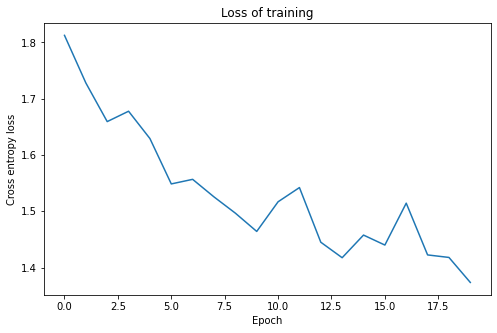

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model D: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 8000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        #self.dropout1 = nn.Dropout(0.2)
        # non-linearity 1
        self.relu1 = nn.LeakyReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.LeakyReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.dropout2 = nn.Dropout(0.25)
        # non-linearity 3
        self.relu3 = nn.LeakyReLU()
        
        # linear function 4 (readout) 
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        #out = self.dropout1(out)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        #out = self.dropout1(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        out = self.dropout2(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 10
hidden_dim1 = 1530
hidden_dim2 = 768
hidden_dim3 = 384 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [ ]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1530]       4,701,690
         LeakyReLU-2              [-1, 1, 1530]               0
            Linear-3               [-1, 1, 768]       1,175,808
         LeakyReLU-4               [-1, 1, 768]               0
            Linear-5               [-1, 1, 384]         295,296
           Dropout-6               [-1, 1, 384]               0
         LeakyReLU-7               [-1, 1, 384]               0
            Linear-8                [-1, 1, 10]           3,850
Total params: 6,176,644
Trainable params: 6,176,644
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 23.56
Estimated Total Size (MB): 23.62
----------------------------------------------------------------


In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.09
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/391 | Cost: 11.9137
Epoch: 001/020 Train Cost: 1.7357
Time elapsed: 0.06 min
Epoch: 002/020 | Batch 000/391 | Cost: 1.7874
Epoch: 002/020 Train Cost: 1.6275
Time elapsed: 0.12 min
Epoch: 003/020 | Batch 000/391 | Cost: 1.5782
Epoch: 003/020 Train Cost: 1.5847
Time elapsed: 0.18 min
Epoch: 004/020 | Batch 000/391 | Cost: 1.6649
Epoch: 004/020 Train Cost: 1.5310
Time elapsed: 0.23 min
Epoch: 005/020 | Batch 000/391 | Cost: 1.6077
Epoch: 005/020 Train Cost: 1.5155
Time elapsed: 0.29 min
Epoch: 006/020 | Batch 000/391 | Cost: 1.4629
Epoch: 006/020 Train Cost: 1.5373
Time elapsed: 0.35 min
Epoch: 007/020 | Batch 000/391 | Cost: 1.5562
Epoch: 007/020 Train Cost: 1.4886
Time elapsed: 0.41 min
Epoch: 008/020 | Batch 000/391 | Cost: 1.5789
Epoch: 008/020 Train Cost: 1.4345
Time elapsed: 0.46 min
Epoch: 009/020 | Batch 000/391 | Cost: 1.5385
Epoch: 009/020 Train Cost: 1.4407
Time elapsed: 0.52 min
Epoch: 010/020 | Batch 000/391 | Cost: 1.3597
Epoch: 010/020 Train Cost:

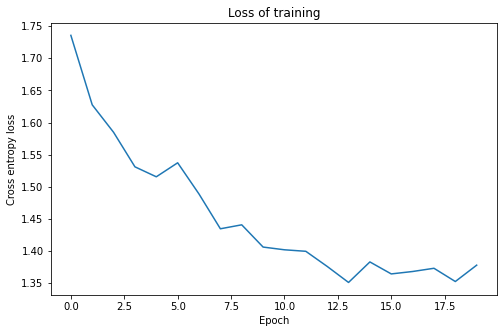

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## **Optimization:** Different optimizers and batch normalization

## 1. SGD

### Model C: 3 Hidden Layers Feedforward Neural Network (ReLU and LeakyReLU Activation functions)

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 8000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        # non-linearity 1
        self.relu1 = nn.LeakyReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.LeakyReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.dropout2 = nn.Dropout(0.3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        out = self.dropout1(out)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        out = self.dropout2(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 10
hidden_dim1 = 700
hidden_dim2 = 1200
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [ ]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 700]       2,151,100
           Dropout-2               [-1, 1, 700]               0
         LeakyReLU-3               [-1, 1, 700]               0
            Linear-4              [-1, 1, 1200]         841,200
         LeakyReLU-5              [-1, 1, 1200]               0
            Linear-6               [-1, 1, 512]         614,912
           Dropout-7               [-1, 1, 512]               0
              ReLU-8               [-1, 1, 512]               0
            Linear-9                [-1, 1, 10]           5,130
Total params: 3,612,342
Trainable params: 3,612,342
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 13.78
Estimated Total Size (MB): 13.84
-------------------------------------

In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.08
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/391 | Cost: 11.2107
Epoch: 001/020 Train Cost: 1.8391
Time elapsed: 0.06 min
Epoch: 002/020 | Batch 000/391 | Cost: 1.8100
Epoch: 002/020 Train Cost: 1.7494
Time elapsed: 0.12 min
Epoch: 003/020 | Batch 000/391 | Cost: 1.9003
Epoch: 003/020 Train Cost: 1.6826
Time elapsed: 0.18 min
Epoch: 004/020 | Batch 000/391 | Cost: 1.7250
Epoch: 004/020 Train Cost: 1.6269
Time elapsed: 0.24 min
Epoch: 005/020 | Batch 000/391 | Cost: 1.7205
Epoch: 005/020 Train Cost: 1.5872
Time elapsed: 0.30 min
Epoch: 006/020 | Batch 000/391 | Cost: 1.7388
Epoch: 006/020 Train Cost: 1.5639
Time elapsed: 0.36 min
Epoch: 007/020 | Batch 000/391 | Cost: 1.6524
Epoch: 007/020 Train Cost: 1.5472
Time elapsed: 0.42 min
Epoch: 008/020 | Batch 000/391 | Cost: 1.5560
Epoch: 008/020 Train Cost: 1.5031
Time elapsed: 0.48 min
Epoch: 009/020 | Batch 000/391 | Cost: 1.4138
Epoch: 009/020 Train Cost: 1.5149
Time elapsed: 0.54 min
Epoch: 010/020 | Batch 000/391 | Cost: 1.5097
Epoch: 010/020 Train Cost:

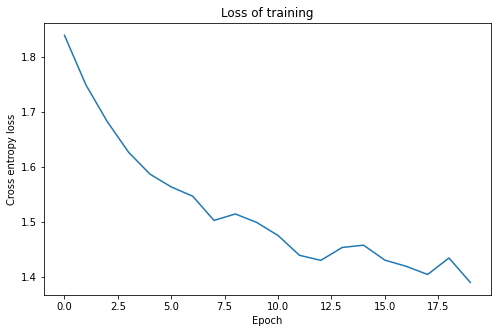

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 2. SGD Momentum

### Model C: 3 Hidden Layers Feedforward Neural Network (ReLU and LeakyReLU Activation functions)

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 8000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        # non-linearity 1
        self.relu1 = nn.LeakyReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.LeakyReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.dropout2 = nn.Dropout(0.3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        out = self.dropout1(out)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        out = self.dropout2(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 10
hidden_dim1 = 700
hidden_dim2 = 1200
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [ ]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 700]       2,151,100
           Dropout-2               [-1, 1, 700]               0
         LeakyReLU-3               [-1, 1, 700]               0
            Linear-4              [-1, 1, 1200]         841,200
         LeakyReLU-5              [-1, 1, 1200]               0
            Linear-6               [-1, 1, 512]         614,912
           Dropout-7               [-1, 1, 512]               0
              ReLU-8               [-1, 1, 512]               0
            Linear-9                [-1, 1, 10]           5,130
Total params: 3,612,342
Trainable params: 3,612,342
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 13.78
Estimated Total Size (MB): 13.84
-------------------------------------

In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.08
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA, momentum=0.7)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/391 | Cost: 9.4511
Epoch: 001/020 Train Cost: 1.8292
Time elapsed: 0.06 min
Epoch: 002/020 | Batch 000/391 | Cost: 1.8280
Epoch: 002/020 Train Cost: 1.7555
Time elapsed: 0.13 min
Epoch: 003/020 | Batch 000/391 | Cost: 1.9066
Epoch: 003/020 Train Cost: 1.6632
Time elapsed: 0.19 min
Epoch: 004/020 | Batch 000/391 | Cost: 1.7118
Epoch: 004/020 Train Cost: 1.6258
Time elapsed: 0.25 min
Epoch: 005/020 | Batch 000/391 | Cost: 1.7468
Epoch: 005/020 Train Cost: 1.5924
Time elapsed: 0.31 min
Epoch: 006/020 | Batch 000/391 | Cost: 1.8293
Epoch: 006/020 Train Cost: 1.5588
Time elapsed: 0.37 min
Epoch: 007/020 | Batch 000/391 | Cost: 1.5755
Epoch: 007/020 Train Cost: 1.5337
Time elapsed: 0.44 min
Epoch: 008/020 | Batch 000/391 | Cost: 1.5079
Epoch: 008/020 Train Cost: 1.5491
Time elapsed: 0.50 min
Epoch: 009/020 | Batch 000/391 | Cost: 1.6266
Epoch: 009/020 Train Cost: 1.4956
Time elapsed: 0.56 min
Epoch: 010/020 | Batch 000/391 | Cost: 1.4234
Epoch: 010/020 Train Cost: 

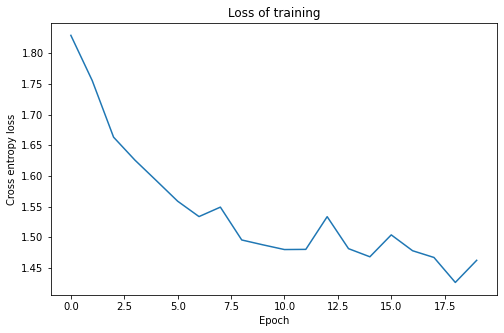

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 3. SGD Nesterov

### Model C: 3 Hidden Layers Feedforward Neural Network (ReLU and LeakyReLU Activation functions)

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 8000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        # non-linearity 1
        self.relu1 = nn.LeakyReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.LeakyReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.dropout2 = nn.Dropout(0.3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        out = self.dropout1(out)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        out = self.dropout2(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 10
hidden_dim1 = 700
hidden_dim2 = 1200
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [ ]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 700]       2,151,100
           Dropout-2               [-1, 1, 700]               0
         LeakyReLU-3               [-1, 1, 700]               0
            Linear-4              [-1, 1, 1200]         841,200
         LeakyReLU-5              [-1, 1, 1200]               0
            Linear-6               [-1, 1, 512]         614,912
           Dropout-7               [-1, 1, 512]               0
              ReLU-8               [-1, 1, 512]               0
            Linear-9                [-1, 1, 10]           5,130
Total params: 3,612,342
Trainable params: 3,612,342
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 13.78
Estimated Total Size (MB): 13.84
-------------------------------------

In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.08
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA, momentum=0.7, nesterov=True)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/391 | Cost: 11.8700
Epoch: 001/020 Train Cost: 1.8370
Time elapsed: 0.06 min
Epoch: 002/020 | Batch 000/391 | Cost: 1.7952
Epoch: 002/020 Train Cost: 1.7462
Time elapsed: 0.12 min
Epoch: 003/020 | Batch 000/391 | Cost: 1.7676
Epoch: 003/020 Train Cost: 1.7176
Time elapsed: 0.19 min
Epoch: 004/020 | Batch 000/391 | Cost: 1.8069
Epoch: 004/020 Train Cost: 1.6548
Time elapsed: 0.25 min
Epoch: 005/020 | Batch 000/391 | Cost: 1.6702
Epoch: 005/020 Train Cost: 1.6344
Time elapsed: 0.31 min
Epoch: 006/020 | Batch 000/391 | Cost: 1.6754
Epoch: 006/020 Train Cost: 1.5675
Time elapsed: 0.37 min
Epoch: 007/020 | Batch 000/391 | Cost: 1.5975
Epoch: 007/020 Train Cost: 1.5823
Time elapsed: 0.43 min
Epoch: 008/020 | Batch 000/391 | Cost: 1.8013
Epoch: 008/020 Train Cost: 1.5739
Time elapsed: 0.50 min
Epoch: 009/020 | Batch 000/391 | Cost: 1.5976
Epoch: 009/020 Train Cost: 1.5251
Time elapsed: 0.56 min
Epoch: 010/020 | Batch 000/391 | Cost: 1.5160
Epoch: 010/020 Train Cost:

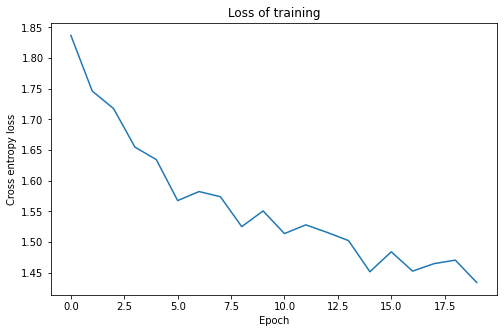

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 4. Adam

### Model C: 3 Hidden Layers Feedforward Neural Network (ReLU and LeakyReLU Activation functions)

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 8000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        # non-linearity 1
        self.relu1 = nn.LeakyReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.LeakyReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.dropout2 = nn.Dropout(0.3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        out = self.dropout1(out)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        out = self.dropout2(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 10
hidden_dim1 = 700
hidden_dim2 = 1200
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [ ]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 700]       2,151,100
           Dropout-2               [-1, 1, 700]               0
         LeakyReLU-3               [-1, 1, 700]               0
            Linear-4              [-1, 1, 1200]         841,200
         LeakyReLU-5              [-1, 1, 1200]               0
            Linear-6               [-1, 1, 512]         614,912
           Dropout-7               [-1, 1, 512]               0
              ReLU-8               [-1, 1, 512]               0
            Linear-9                [-1, 1, 10]           5,130
Total params: 3,612,342
Trainable params: 3,612,342
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 13.78
Estimated Total Size (MB): 13.84
-------------------------------------

In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.08
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/391 | Cost: 16.2037
Epoch: 001/020 Train Cost: 1.9559
Time elapsed: 0.07 min
Epoch: 002/020 | Batch 000/391 | Cost: 2.0145
Epoch: 002/020 Train Cost: 1.9666
Time elapsed: 0.13 min
Epoch: 003/020 | Batch 000/391 | Cost: 2.0386
Epoch: 003/020 Train Cost: 1.9505
Time elapsed: 0.20 min
Epoch: 004/020 | Batch 000/391 | Cost: 2.0625
Epoch: 004/020 Train Cost: 1.8866
Time elapsed: 0.27 min
Epoch: 005/020 | Batch 000/391 | Cost: 2.0247
Epoch: 005/020 Train Cost: 1.9144
Time elapsed: 0.33 min
Epoch: 006/020 | Batch 000/391 | Cost: 1.9358
Epoch: 006/020 Train Cost: 1.8845
Time elapsed: 0.40 min
Epoch: 007/020 | Batch 000/391 | Cost: 1.9324
Epoch: 007/020 Train Cost: 1.8608
Time elapsed: 0.46 min
Epoch: 008/020 | Batch 000/391 | Cost: 2.0420
Epoch: 008/020 Train Cost: 1.9698
Time elapsed: 0.53 min
Epoch: 009/020 | Batch 000/391 | Cost: 2.1424
Epoch: 009/020 Train Cost: 1.9062
Time elapsed: 0.59 min
Epoch: 010/020 | Batch 000/391 | Cost: 1.9941
Epoch: 010/020 Train Cost:

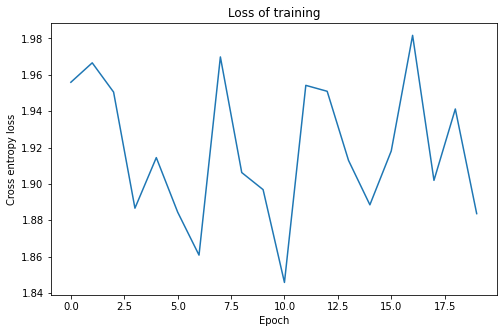

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 5. Adagrad

### Model C: 3 Hidden Layers Feedforward Neural Network (ReLU and LeakyReLU Activation functions)

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 8000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        # non-linearity 1
        self.relu1 = nn.LeakyReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.LeakyReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.dropout2 = nn.Dropout(0.3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        out = self.dropout1(out)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        out = self.dropout2(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 10
hidden_dim1 = 700
hidden_dim2 = 1200
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [ ]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 700]       2,151,100
           Dropout-2               [-1, 1, 700]               0
         LeakyReLU-3               [-1, 1, 700]               0
            Linear-4              [-1, 1, 1200]         841,200
         LeakyReLU-5              [-1, 1, 1200]               0
            Linear-6               [-1, 1, 512]         614,912
           Dropout-7               [-1, 1, 512]               0
              ReLU-8               [-1, 1, 512]               0
            Linear-9                [-1, 1, 10]           5,130
Total params: 3,612,342
Trainable params: 3,612,342
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 13.78
Estimated Total Size (MB): 13.84
-------------------------------------

In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.08
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/391 | Cost: 10.2497
Epoch: 001/020 Train Cost: 1.8385
Time elapsed: 0.06 min
Epoch: 002/020 | Batch 000/391 | Cost: 1.8886
Epoch: 002/020 Train Cost: 1.7305
Time elapsed: 0.12 min
Epoch: 003/020 | Batch 000/391 | Cost: 1.8053
Epoch: 003/020 Train Cost: 1.6646
Time elapsed: 0.19 min
Epoch: 004/020 | Batch 000/391 | Cost: 1.6620
Epoch: 004/020 Train Cost: 1.6341
Time elapsed: 0.25 min
Epoch: 005/020 | Batch 000/391 | Cost: 1.6546
Epoch: 005/020 Train Cost: 1.6017
Time elapsed: 0.31 min
Epoch: 006/020 | Batch 000/391 | Cost: 1.7096
Epoch: 006/020 Train Cost: 1.5716
Time elapsed: 0.37 min
Epoch: 007/020 | Batch 000/391 | Cost: 1.6439
Epoch: 007/020 Train Cost: 1.5558
Time elapsed: 0.43 min
Epoch: 008/020 | Batch 000/391 | Cost: 1.4705
Epoch: 008/020 Train Cost: 1.5259
Time elapsed: 0.49 min
Epoch: 009/020 | Batch 000/391 | Cost: 1.5881
Epoch: 009/020 Train Cost: 1.5248
Time elapsed: 0.55 min
Epoch: 010/020 | Batch 000/391 | Cost: 1.7606
Epoch: 010/020 Train Cost:

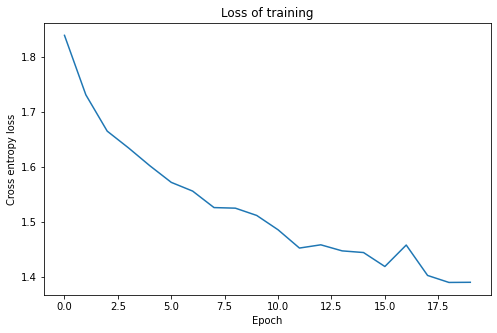

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 6. Adadelta

### Model C: 3 Hidden Layers Feedforward Neural Network (ReLU and LeakyReLU Activation functions)

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 8000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        # non-linearity 1
        self.relu1 = nn.LeakyReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.LeakyReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.dropout2 = nn.Dropout(0.3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        out = self.dropout1(out)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        out = self.dropout2(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 10
hidden_dim1 = 700
hidden_dim2 = 1200
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [ ]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 700]       2,151,100
           Dropout-2               [-1, 1, 700]               0
         LeakyReLU-3               [-1, 1, 700]               0
            Linear-4              [-1, 1, 1200]         841,200
         LeakyReLU-5              [-1, 1, 1200]               0
            Linear-6               [-1, 1, 512]         614,912
           Dropout-7               [-1, 1, 512]               0
              ReLU-8               [-1, 1, 512]               0
            Linear-9                [-1, 1, 10]           5,130
Total params: 3,612,342
Trainable params: 3,612,342
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 13.78
Estimated Total Size (MB): 13.84
-------------------------------------

In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.08
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/391 | Cost: 9.6053
Epoch: 001/020 Train Cost: 1.9787
Time elapsed: 0.07 min
Epoch: 002/020 | Batch 000/391 | Cost: 2.4985
Epoch: 002/020 Train Cost: 1.8765
Time elapsed: 0.14 min
Epoch: 003/020 | Batch 000/391 | Cost: 2.0497
Epoch: 003/020 Train Cost: 1.8179
Time elapsed: 0.20 min
Epoch: 004/020 | Batch 000/391 | Cost: 1.9087
Epoch: 004/020 Train Cost: 1.7730
Time elapsed: 0.27 min
Epoch: 005/020 | Batch 000/391 | Cost: 1.8090
Epoch: 005/020 Train Cost: 1.7386
Time elapsed: 0.34 min
Epoch: 006/020 | Batch 000/391 | Cost: 1.8338
Epoch: 006/020 Train Cost: 1.7136
Time elapsed: 0.41 min
Epoch: 007/020 | Batch 000/391 | Cost: 1.9946
Epoch: 007/020 Train Cost: 1.6885
Time elapsed: 0.47 min
Epoch: 008/020 | Batch 000/391 | Cost: 1.8158
Epoch: 008/020 Train Cost: 1.6692
Time elapsed: 0.54 min
Epoch: 009/020 | Batch 000/391 | Cost: 1.8742
Epoch: 009/020 Train Cost: 1.6438
Time elapsed: 0.61 min
Epoch: 010/020 | Batch 000/391 | Cost: 1.8521
Epoch: 010/020 Train Cost: 

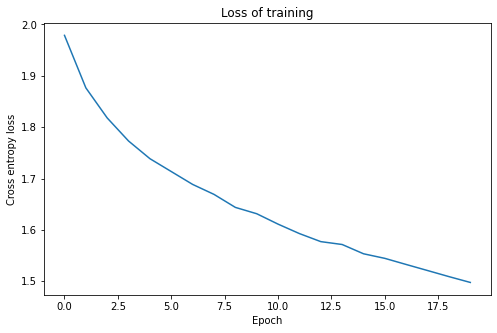

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 7. Adamax

### Model C: 3 Hidden Layers Feedforward Neural Network (ReLU and LeakyReLU Activation functions)

#### Make dataset iterable

In [156]:
batch_size = 128
n_iters = 8000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [157]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [158]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        # non-linearity 1
        self.relu1 = nn.LeakyReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.LeakyReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.dropout2 = nn.Dropout(0.3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        out = self.dropout1(out)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        out = self.dropout2(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [159]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 10
hidden_dim1 = 700
hidden_dim2 = 1200
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [160]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 700]       2,151,100
           Dropout-2               [-1, 1, 700]               0
         LeakyReLU-3               [-1, 1, 700]               0
            Linear-4              [-1, 1, 1200]         841,200
         LeakyReLU-5              [-1, 1, 1200]               0
            Linear-6               [-1, 1, 512]         614,912
           Dropout-7               [-1, 1, 512]               0
              ReLU-8               [-1, 1, 512]               0
            Linear-9                [-1, 1, 10]           5,130
Total params: 3,612,342
Trainable params: 3,612,342
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 13.78
Estimated Total Size (MB): 13.84
-------------------------------------

In [161]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.08
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [162]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/391 | Cost: 13.1671
Epoch: 001/020 Train Cost: 1.8658
Time elapsed: 0.07 min
Epoch: 002/020 | Batch 000/391 | Cost: 1.9820
Epoch: 002/020 Train Cost: 1.7788
Time elapsed: 0.14 min
Epoch: 003/020 | Batch 000/391 | Cost: 1.9453
Epoch: 003/020 Train Cost: 1.7605
Time elapsed: 0.21 min
Epoch: 004/020 | Batch 000/391 | Cost: 1.8686
Epoch: 004/020 Train Cost: 1.7548
Time elapsed: 0.28 min
Epoch: 005/020 | Batch 000/391 | Cost: 1.8200
Epoch: 005/020 Train Cost: 1.7205
Time elapsed: 0.35 min
Epoch: 006/020 | Batch 000/391 | Cost: 1.7970
Epoch: 006/020 Train Cost: 1.7479
Time elapsed: 0.42 min
Epoch: 007/020 | Batch 000/391 | Cost: 1.7557
Epoch: 007/020 Train Cost: 1.7970
Time elapsed: 0.49 min
Epoch: 008/020 | Batch 000/391 | Cost: 1.7976
Epoch: 008/020 Train Cost: 1.6968
Time elapsed: 0.56 min
Epoch: 009/020 | Batch 000/391 | Cost: 1.7623
Epoch: 009/020 Train Cost: 1.7859
Time elapsed: 0.63 min
Epoch: 010/020 | Batch 000/391 | Cost: 1.8394
Epoch: 010/020 Train Cost:

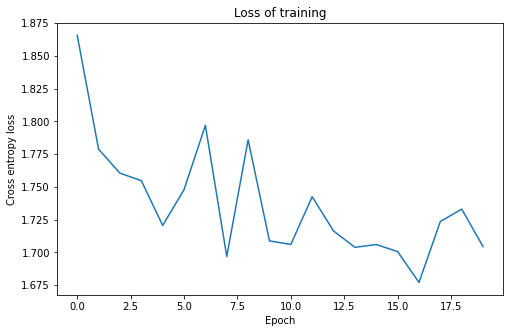

In [163]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 8. RMSProp

### Model C: 3 Hidden Layers Feedforward Neural Network (ReLU and LeakyReLU Activation functions)

#### Make dataset iterable

In [191]:
batch_size = 128
n_iters = 8000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [192]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [193]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        # non-linearity 1
        self.relu1 = nn.LeakyReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.LeakyReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.dropout2 = nn.Dropout(0.3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        out = self.dropout1(out)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        out = self.dropout2(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [194]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 10
hidden_dim1 = 700
hidden_dim2 = 1200
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [195]:
summary(model, (1,3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 700]       2,151,100
           Dropout-2               [-1, 1, 700]               0
         LeakyReLU-3               [-1, 1, 700]               0
            Linear-4              [-1, 1, 1200]         841,200
         LeakyReLU-5              [-1, 1, 1200]               0
            Linear-6               [-1, 1, 512]         614,912
           Dropout-7               [-1, 1, 512]               0
              ReLU-8               [-1, 1, 512]               0
            Linear-9                [-1, 1, 10]           5,130
Total params: 3,612,342
Trainable params: 3,612,342
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 13.78
Estimated Total Size (MB): 13.84
-------------------------------------

In [196]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.08
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=LAMBDA, momentum=0.5)

#### Train the model

In [197]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/391 | Cost: 11.5253
Epoch: 001/020 Train Cost: 2.3085
Time elapsed: 0.07 min
Epoch: 002/020 | Batch 000/391 | Cost: 2.3029
Epoch: 002/020 Train Cost: 2.3089
Time elapsed: 0.13 min
Epoch: 003/020 | Batch 000/391 | Cost: 2.3051
Epoch: 003/020 Train Cost: 2.3087
Time elapsed: 0.20 min
Epoch: 004/020 | Batch 000/391 | Cost: 2.3043
Epoch: 004/020 Train Cost: 2.3085
Time elapsed: 0.26 min
Epoch: 005/020 | Batch 000/391 | Cost: 2.3016
Epoch: 005/020 Train Cost: 2.3088
Time elapsed: 0.33 min
Epoch: 006/020 | Batch 000/391 | Cost: 2.3052
Epoch: 006/020 Train Cost: 2.3093
Time elapsed: 0.39 min
Epoch: 007/020 | Batch 000/391 | Cost: 2.2998
Epoch: 007/020 Train Cost: 2.3086
Time elapsed: 0.46 min
Epoch: 008/020 | Batch 000/391 | Cost: 2.3038
Epoch: 008/020 Train Cost: 2.3086
Time elapsed: 0.52 min
Epoch: 009/020 | Batch 000/391 | Cost: 2.3022
Epoch: 009/020 Train Cost: 2.3105
Time elapsed: 0.59 min
Epoch: 010/020 | Batch 000/391 | Cost: 2.2973
Epoch: 010/020 Train Cost:

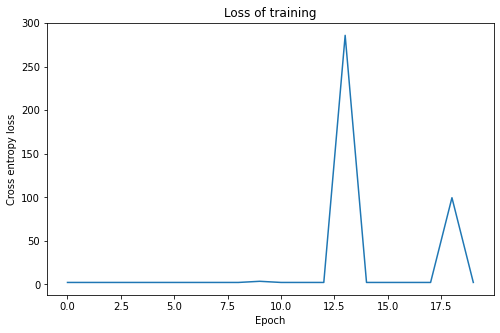

In [198]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## Batch normalization

### Model C: 3 Hidden Layers Feedforward Neural Network (ReLU and LeakyReLU Activation functions)

#### Make dataset iterable

In [15]:
batch_size = 128
n_iters = 8000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

20


In [16]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) # create your dataloader

### Create model class

In [23]:
class FeedforwardNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(FeedforwardNeuralNetworkModel, self).__init__()
        # linear function 1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        
        self.dropout1 = nn.Dropout(0.2)
        # non-linearity 1
        self.relu1 = nn.LeakyReLU()
        
        # linear function 2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.BatchNorm1d1=nn.BatchNorm1d(hidden_dim2)
        # non-linearity 2
        self.relu2 = nn.LeakyReLU()
        
        # linear function 3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.BatchNorm1d2=nn.BatchNorm1d(hidden_dim3)
        self.dropout2 = nn.Dropout(0.3)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        
        out = self.dropout1(out)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        out = self.BatchNorm1d1(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        out = self.BatchNorm1d2(out)
        out = self.dropout2(out)
        # non-linearity 3
        out = self.relu3(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [24]:
#  Instantiate model class
input_dim = 3*32*32
output_dim = 10
hidden_dim1 = 700
hidden_dim2 = 1200
hidden_dim3 = 512 

model = FeedforwardNeuralNetworkModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()
    

In [25]:
#summary(model, (1,3*32*32))

In [26]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
LAMBDA = 0.08
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [27]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 3*32*32).to(device)
        targets = targets.to(device)    
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/391 | Cost: 2.4250
Epoch: 001/020 Train Cost: 1.9226
Time elapsed: 0.06 min
Epoch: 002/020 | Batch 000/391 | Cost: 1.9087
Epoch: 002/020 Train Cost: 1.7964
Time elapsed: 0.11 min
Epoch: 003/020 | Batch 000/391 | Cost: 1.8437
Epoch: 003/020 Train Cost: 1.7324
Time elapsed: 0.16 min
Epoch: 004/020 | Batch 000/391 | Cost: 1.6889
Epoch: 004/020 Train Cost: 1.6851
Time elapsed: 0.22 min
Epoch: 005/020 | Batch 000/391 | Cost: 1.7001
Epoch: 005/020 Train Cost: 1.6436
Time elapsed: 0.27 min
Epoch: 006/020 | Batch 000/391 | Cost: 1.6540
Epoch: 006/020 Train Cost: 1.6192
Time elapsed: 0.33 min
Epoch: 007/020 | Batch 000/391 | Cost: 1.7415
Epoch: 007/020 Train Cost: 1.5918
Time elapsed: 0.38 min
Epoch: 008/020 | Batch 000/391 | Cost: 1.6408
Epoch: 008/020 Train Cost: 1.5723
Time elapsed: 0.43 min
Epoch: 009/020 | Batch 000/391 | Cost: 1.4983
Epoch: 009/020 Train Cost: 1.5554
Time elapsed: 0.49 min
Epoch: 010/020 | Batch 000/391 | Cost: 1.6025
Epoch: 010/020 Train Cost: 

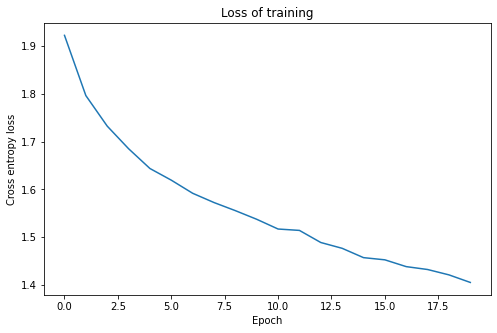

In [28]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## Results of regularizations

| Model Name                    | Training Accuracy | Test Accuracy | Training Accuracy(Dropout) | Test Accuracy(Dropout) | 
|--------------------------------|----------|----------|----------|----------|
| Model C |  55.53  |  50.37  |  52.30   |  49.67   |
| Model D |  56.00  |  51.00  |   51.79  |  48.03   |

## Results of optimizations (Test accuracy)
- With dropouts from the regularization part
- Best optimizer for each model is bolded

| Optimizer                    | Model C |
|--------------------------------|----------|
| **SGD** |  **48.62**  | 
| SGD Momentum |  45.91  |
| SGD Nesterov |  47.03  | 
| Adam |  31.33 |
| Adagrad |  48.30  |
| Adadelta |  46.01  |
| Adamax |  40.04  | 
| RMSProp |  10.00  | 


### Batch normalozation
- With dropouts from the regularization part
- We employed the best optimizer for the models from the previous table

| Model Name | Optimizer| Training Accuracy | Test Accuracy |
|------------|----------|----------|----------|
| Model C |  SGD |  52.31  |  49.69  |